In [ ]:
!nvidia-smi

Sat Nov  5 23:51:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    49W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Bachelorarbeit/Dataset



Mounted at /content/drive
/content/drive/MyDrive/Bachelorarbeit/Dataset


In [ ]:
pip install transformers torchmetrics datasets

In [ ]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import AdamW
from transformers import GPT2Tokenizer, TrainingArguments, Trainer, GPTNeoForCausalLM, AutoModelForCausalLM, AutoTokenizer
from datasets import Dataset
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-125M", pad_token='<|pad|>')
model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M")

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/560 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/526M [00:00<?, ?B/s]

In [ ]:
SPECIAL_TOKENS = {
    'additional_special_tokens': ['<|context|>','<|slogan|>'],
}

tokenizer.add_special_tokens(SPECIAL_TOKENS)
model.resize_token_embeddings(len(tokenizer))

Embedding(50260, 768)

In [ ]:
dataset_path = pd.read_csv('./slogans_extended.csv')
if dataset_path.duplicated().any():
  print("Dataset contains duplicates!")
else:
  print("No duplicates in dataset")

print("Count Rows: ",dataset_path.count())
dataset_path = dataset_path.drop_duplicates()
print("Count Rows after drop duplicates: ",dataset_path.count())

Dataset contains duplicates!
Count Rows:  company    11183
slogan     11181
dtype: int64
Count Rows after drop duplicates:  company    10573
slogan     10571
dtype: int64


In [ ]:
class SloganDataset(Dataset):

  def __init__(self, dataset, tokenizer, seq_length=64):

    context_tkn = tokenizer.additional_special_tokens_ids[0]
    slogan_tkn = tokenizer.additional_special_tokens_ids[1]
    pad_tkn = tokenizer.pad_token_id
    eos_tkn = tokenizer.eos_token_id

    self.tokenized_data = []

    #dataset = pd.read_csv(dataset)
    dataset = dataset.drop_duplicates()

    for _, data in dataset.iterrows():

        # Build the context and slogan segments:
        context = [context_tkn] + tokenizer.encode(str(data[0]), max_length=seq_length//2-1)
        slogan = [slogan_tkn] + tokenizer.encode(str(data[1]), max_length=seq_length//2-2) + [eos_tkn]
        
        # Concatenate the two parts together:
        tokens = context + slogan + [pad_tkn] * ( seq_length - len(context) - len(slogan) )

        # Annotate each token with its corresponding segment:
        segments = [context_tkn] * len(context) + [slogan_tkn] * ( seq_length - len(context) )

        # Ignore the context, padding, and <slogan> tokens by setting their labels to -100
        labels = [-100] * (len(context)+1) + slogan[1:] + [-100] * ( seq_length - len(context) - len(slogan) )

        # Add the preprocessed example to the dataset
        self.tokenized_data.append((tokens, segments, labels))

  def __len__(self):
    return len(self.tokenized_data)

  def __getitem__(self, item):
    return torch.tensor(self.tokenized_data[item])




In [ ]:
slogan_dataset = SloganDataset(dataset_path, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
train, val = train_test_split(slogan_dataset, train_size=0.80)

train_dl = DataLoader(train, batch_size=16, shuffle=True)
val_dl = DataLoader(val, batch_size=32, shuffle=True)

In [ ]:
def train(model, optimizer, train_dl,val_dl, epochs=1, device=torch.device('cpu')):
  epoch_list=[]
  train_costs = []
  val_costs = []
  for epoch in range(epochs):
    print(f"!----Start epoch #{epoch}----!")
    model.train()

    epoch_list.append(epoch)
    losses=[]
    sizes=[]
    batches=[]
    

    for i, batch in enumerate(tqdm(train_dl,desc="Training")):

      #Batch shape = [16,3,64] >> 16 mal 3 (input_token_ids, segment_token_ids, labels) mit jeweils einer squenzlänge von 64
      inputs=batch.to(device)

      #inputs[:,0,:] = input_token_ids, inputs[:,1,:] = segment_token_ids, inputs[:,2,:] = labels (der zu lernende Slogan)
      outputs = model(inputs[:,0,:], token_type_ids=inputs[:,1,:], labels=inputs[:,2,:])

      loss = outputs[0]
      losses.append(loss.item())
      sizes.append(len(batch))
      batches.append(i)

      loss.backward()

      optimizer.step()
      model.zero_grad()

      
    train_cost = np.sum(np.multiply(losses, sizes)) / sum(sizes)
    train_costs.append(train_cost)
    print("\nTrain cost: ", train_cost)
    

    model.eval()

    with torch.no_grad():
      losses = []
      sizes = []
      

      for i, batch in enumerate(tqdm(val_dl,desc="Validation")):
        inputs=batch.to(device)
        outputs = model(inputs[:,0,:], token_type_ids=inputs[:,1,:], labels=inputs[:,2,:])
        loss = outputs[0]
        losses.append(loss.item())
        sizes.append(len(batch))
        
      val_cost = np.sum(np.multiply(losses, sizes)) / sum(sizes)
      val_costs.append(val_cost)
      print("\nValidation cost: ", val_cost)
        

  return epoch_list, train_costs, val_costs

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-3)

device = torch.device('cuda')
model.to(device)

epoch_list, train_costs, val_costs = train(model,optimizer, train_dl, val_dl, epochs=8,device=device)

!----Start epoch #0----!


Training: 100%|██████████| 529/529 [02:33<00:00,  3.45it/s]



Train cost:  7.911733983509589


Validation: 100%|██████████| 67/67 [00:11<00:00,  5.98it/s]



Validation cost:  6.415842590377122
!----Start epoch #1----!


Training: 100%|██████████| 529/529 [02:32<00:00,  3.46it/s]



Train cost:  5.883957077296075


Validation: 100%|██████████| 67/67 [00:11<00:00,  5.97it/s]



Validation cost:  5.237110916435296
!----Start epoch #2----!


Training: 100%|██████████| 529/529 [02:32<00:00,  3.46it/s]



Train cost:  4.384681796824631


Validation: 100%|██████████| 67/67 [00:11<00:00,  5.97it/s]



Validation cost:  4.570627959231113
!----Start epoch #3----!


Training: 100%|██████████| 529/529 [02:32<00:00,  3.46it/s]



Train cost:  3.577104379167284


Validation: 100%|██████████| 67/67 [00:11<00:00,  5.95it/s]



Validation cost:  3.833360248930911
!----Start epoch #4----!


Training: 100%|██████████| 529/529 [02:32<00:00,  3.46it/s]



Train cost:  2.8580575296010045


Validation: 100%|██████████| 67/67 [00:11<00:00,  5.96it/s]



Validation cost:  3.464059827457365
!----Start epoch #5----!


Training: 100%|██████████| 529/529 [02:32<00:00,  3.46it/s]



Train cost:  2.2820325821222327


Validation: 100%|██████████| 67/67 [00:11<00:00,  5.95it/s]



Validation cost:  3.4712514363282114
!----Start epoch #6----!


Training: 100%|██████████| 529/529 [02:32<00:00,  3.46it/s]



Train cost:  1.7706599020738076


Validation: 100%|██████████| 67/67 [00:11<00:00,  5.96it/s]



Validation cost:  3.5954925212454287
!----Start epoch #7----!


Training: 100%|██████████| 529/529 [02:32<00:00,  3.46it/s]



Train cost:  1.2826412349594036


Validation: 100%|██████████| 67/67 [00:11<00:00,  5.96it/s]


Validation cost:  3.8031651709942107


In [ ]:
d = {"epochs":epoch_list ,
     "train_cost": train_costs,
     "val_cost": val_costs}
df = pd.DataFrame(d)

df.head(10)

,epochs,train_cost,val_cost
0,0,7.911734,6.415843
1,1,5.883957,5.237111
2,2,4.384682,4.570628
3,3,3.577104,3.833360
4,4,2.858058,3.464060
5,5,2.282033,3.471251
6,6,1.770660,3.595493
7,7,1.282641,3.803165


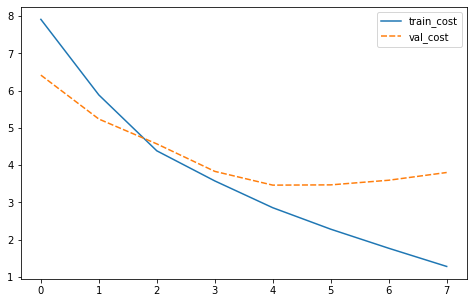

In [ ]:
f, ax = plt.subplots(figsize=(8,5))
sns.lineplot(data=df[["train_cost","val_cost"]])

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Bachelorarbeit/GPTNEO-Model")
tokenizer.save_pretrained("/content/drive/MyDrive/Bachelorarbeit/GPTNEO-Model")